In [36]:
#analysis
import glob
import os, sys
current_dir = os.path.dirname(os.path.realpath('__file__'))
os.path.abspath(os.getcwd())
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT")
sys.path.append("C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation")

import torch
import torch.nn as nn
import torch.optim as optim
# import torch.nn.init as weight_init

import numpy as np
import numpy.ma as ma
import pickle
import re
import time
from tqdm.notebook import tqdm

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.cm as cmx
import sklearn
import sklearn.decomposition

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# from psychrnn.backend.rnn import RNN
from psychrnn.tasks.task import Task

from utils import *
current_dir = 'C:\\Users\\abel_\\Documents\\Rotations\\CIT\cit_for_computation'

In [40]:
#load model
#list experiment folders

exp_list = glob.glob(current_dir+"\\experiments\\*")
exp_list = glob.glob(current_dir+"\\experiments\\nrec_limit\\N*")
exp_list = sorted(exp_list, key = lambda x: int(x[-10:]))

last_i = 2
exp_list[-last_i]

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\nrec_limit\\Nrec1_1655891979'

In [41]:
exp_path = exp_list[-last_i]
idx = exp_path[-10:]

with open(exp_path + '\\training_kwargs.pickle', 'rb') as handle:
    training_kwargs = pickle.load(handle)
    
training_kwargs['exp_path'] = exp_path
training_kwargs['training_weights_path'] = exp_path+'/training/'
training_kwargs['figures_path'] = exp_path + '//figures/'

idx = int(re.search(r'\d+', exp_path).group())

rnn_model = RNNModel(training_kwargs['N_in'], training_kwargs['N_out'], training_kwargs['N_rec'], n_layers=1, transform_function='relu').to(device)

# file = train_params['save_weights_path']+'\\weights%s.pth'%network_params['idx']
rnn_model = load_model(rnn_model, training_kwargs)
rnn_model.eval();

In [42]:
exp_path

'C:\\Users\\abel_\\Documents\\Rotations\\CIT\\cit_for_computation\\experiments\\nrec_limit\\Nrec1_1655891979'

Losses

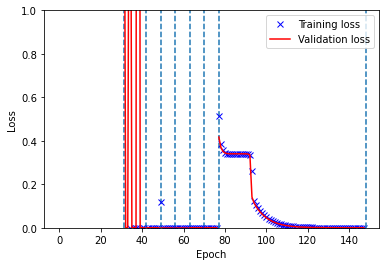

In [43]:
with open(training_kwargs['exp_path'] + '/learning_info.pickle', 'rb') as handle:
    learning_info = pickle.load(handle)
epoch_counter = 0
for coh in sorted(list(learning_info.keys())[:-3]):
    losses = learning_info[str(coh)]['training_loss']
    plt.plot(range(epoch_counter, epoch_counter+len(losses)), losses, 'bx', label="Training loss")
    val_losses = learning_info[str(coh)]['validation_loss']
    plt.plot(range(epoch_counter, epoch_counter+len(losses)), val_losses, 'r', label="Validation loss")
    epoch_counter += len(learning_info[str(coh)]['training_loss'])
    plt.axvline(x=epoch_counter, linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim([0, max([losses[0], val_losses[0]])])
plt.ylim([0, 1])
plt.legend(['Training loss', 'Validation loss'])
plt.savefig(training_kwargs['figures_path'] + '/losses_opt'+training_kwargs['optimizer']+'lr'+str(training_kwargs['learning_rate'])+'.pdf')

 <font size="10">Weights  <font>

In [44]:
rnn_model.state_dict().keys()
# row_labels = ['Z', 'Y', 'X', 'W']
# column_labels = []
# df = pandas.DataFrame(x)
import pandas
weights_dict = {key: pandas.DataFrame(rnn_model.state_dict()[key]) for key in rnn_model.state_dict().keys()}

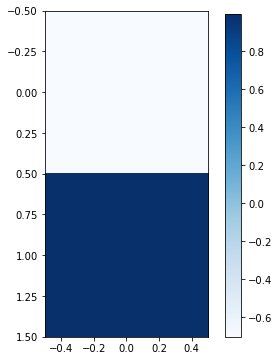

In [45]:
#input weights
W_ih = weights_dict['rnn.weight_ih_l0'] 

fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_ih.T, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)

In [52]:
print("W_in=")
print(W_ih)
b_in = weights_dict['rnn.bias_ih_l0']
print("\n b_in:")
print(b_in)

W_in=
          0         1
0 -0.702842  0.995637

 b_in:
          0
0 -0.649974


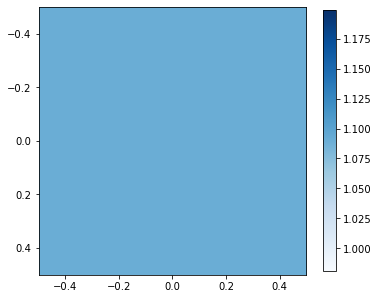

In [47]:
#recurrence weights
W_hh = rnn_model.state_dict()['rnn.weight_hh_l0'] #['rnn.weight_ih_l0']

fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_hh, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.5), shrink=0.8);

In [51]:
print("W_h=")
print(W_hh)

b_h = weights_dict['rnn.bias_hh_l0']
print("\n b_h:")
print(b_h)

W_h=
tensor([[1.0897]])

 b_h:
          0
0  0.358246


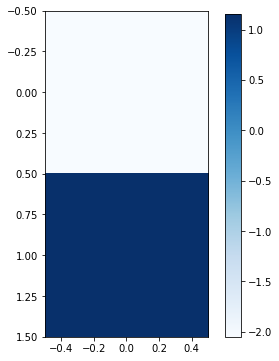

In [49]:
#output weights
W_ho = rnn_model.state_dict()['fc.weight'] 
fig, (ax) = plt.subplots(figsize=(6, 6), ncols=1)
im = ax.imshow(W_ho, cmap='Blues', interpolation='none')
fig.colorbar(im, ax=ax, location='right', anchor=(0, 0.), shrink=0.99)

In [50]:
print("W_out=")
print(W_ho)
print("\n b_out:")
print(weights_dict['fc.bias'])

W_out=
tensor([[-2.0497],
        [ 1.1553]])

 b_out:
          0
0  5.649041
1 -6.161621


# Analytical

In [284]:
b = b_in + b_h
b = b[0].to_numpy()
try:
    W_hh = W_hh.numpy()[0][0]
    b = b[0].to_numpy()
except:
    0

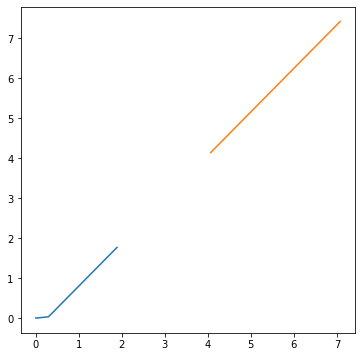

In [307]:
fig = plt.figure(figsize=(6,6))
batch_size = 1
maxT = 20
inputs = [2,4]
for x in inputs:
    inputs = torch.zeros((batch_size, maxT, 2), dtype=torch.float)
    hidden = torch.tensor(x) * torch.ones(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
    hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
    hidden_states = hidden_states.detach().numpy()[0,:]
    plt.plot(hidden_states[:-1], hidden_states[1:])

In [313]:
def lu_step(x, W, b):
    return x*W+b

def relu_step(x, W, b):
    res = x*W+b
    if res < 0:
        return 0
    else:
        return res
    

def relu_step_input(x, W, b, W_ih, I):
    res = x*W+b + np.dot(W_ih, I)
    if res < 0:
        return 0
    else:
        return res

#intersection with x-axis:
print(r"$x_0$: ", -b/W_hh)

#intersection with diagonal line:
x_s = b/(1-W_hh)
x_s = x_s[0]
print(r"$x$: ", x_s)

I = np.array([2, 1])
x_start = 2

# relu_step_input(x_start, W_hh, b, W_ih.to_numpy(), I)

$x_0$:  [0.2677149]
$x$:  3.2524166


In [314]:

xmin, xmax = -1, 10
x = np.linspace(xmin, xmax, 100)

xlu =  np.linspace(-b/W_hh, xmax, 100)
xslope = xlu*W_hh + b
xflat = np.linspace(xmin, -b/W_hh, 100)
yflat = np.zeros(100)

C:\Users\abel_\anaconda3\envs\CIT\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


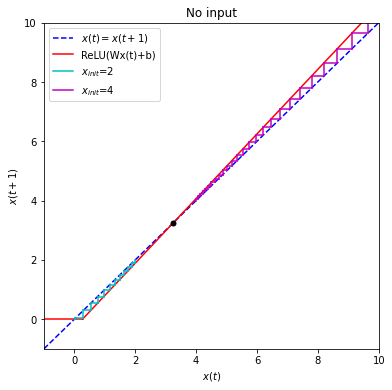

In [318]:
plt.figure(figsize=(6,6))
plt.plot(x, x, '--b', label="$x(t)=x(t+1)$")

plt.plot(xflat, yflat, 'r')
plt.plot(xlu, xslope, 'r', label="ReLU(Wx(t)+b)")

plt.plot(x_s, x_s, 'ko', markersize=5, label='')

#plot paths
x_start = 2 #towards 0
xs = [x_start]
maxT = 200
for i in range(maxT):
    xs.append(relu_step(xs[-1], W_hh, b[0]))
for i, xt1 in enumerate(xs[1:]):
    plt.plot([xs[i], xs[i]], [xs[i], xt1], 'c')
    plt.plot([xt1, xs[i]], [xt1, xt1], 'c')
plt.plot([xt1, xs[i]], [xt1, xt1], 'c', label='$x_{init}$=%s'%x_start)

x_start = 4 #diverges to \infty
xs = [x_start]
for i in range(maxT):
    xs.append(relu_step(xs[-1], W_hh, b))
for i, xt1 in enumerate(xs[1:]):
    plt.plot([xs[i], xs[i]], [xs[i], xt1], 'm')
    plt.plot([xt1, xs[i]], [xt1, xt1], 'm')
plt.plot([xt1, xs[i]], [xt1, xt1], 'm', label='$x_{init}$=%s'%x_start)

#actual trajectories #same as stairwise, but direct
# inputs = [2,4]
# for x_init in inputs:
#     inputs = torch.zeros((batch_size, maxT, 2), dtype=torch.float)
#     hidden = torch.tensor(x_init) * torch.ones(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
#     hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
#     hidden_states = hidden_states.detach().numpy()[0,:]
#     plt.plot(hidden_states[:-1], hidden_states[1:], 'c')
    
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.title("No input")
plt.xlabel("$x(t)$")
plt.ylabel("$x(t+1)$");
plt.legend()

plt.savefig(training_kwargs['figures_path'] + "activation_plot_%s.pdf"%training_kwargs['N_rec'])

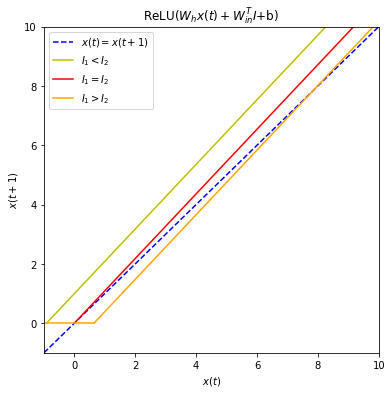

In [260]:
xmin, xmax = -1, 10
x = np.linspace(xmin, xmax, 100)

inputs = np.array([[1,2],
                   [1,1],
                   [2,1]])
colors = ['y', 'r', 'orange']

plt.figure(figsize=(6,6))
plt.plot(x, x, '--b', label="$x(t)=x(t+1)$")
for i,I in enumerate(inputs):
    x_0 = (b+np.dot(W_ih, I))/(W_hh)
    xlu =  np.linspace(-x_0, xmax, 100)
    xslope = xlu*W_hh + b + np.dot(W_ih, I)
    plt.plot(xlu, xslope, color=colors[i])

xflat = np.linspace(xmin, -x_0, 100)
yflat = np.zeros(100)
plt.plot(xflat, yflat, 'orange')
    
plt.legend(["$x(t)=x(t+1)$", "$I_1<I_2$", "$I_1=I_2$", "$I_1>I_2$"])
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.title("ReLU($W_hx(t)+W_{in}^TI$+b)")
plt.xlabel("$x(t)$")
plt.ylabel("$x(t+1)$");
plt.savefig(training_kwargs['figures_path'] + "activation_inputs_N%s.pdf"%training_kwargs['N_rec'])

[[0.9963558]
 [0.9963558]] [[0.29172778]]
[[0.7435236]
 [0.817876 ]] [[0.29172778]]
[[0.5930364]
 [0.7116437]] [[0.29172772]]
[[0.22642088]
 [0.45284176]] [[0.29172775]]


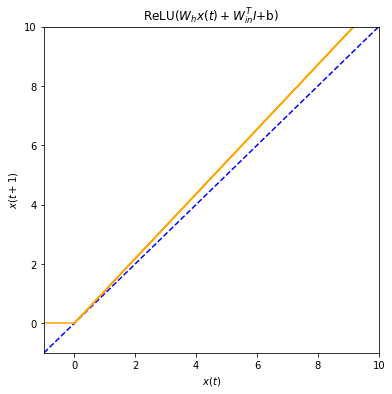

In [283]:
# Saddle-node bifurcation
alpha = 1. #should work for \alpha\in\mathbb{R}
I1 = -b/(W_ih[0]+alpha*W_ih[1])
I2 = alpha*I1
Ibifurcation = np.array([I1, I2])

#intersection with x-axis:
x_0 = (b+np.dot(W_ih, I))/(W_hh)

xmin, xmax = -1, 10
x = np.linspace(xmin, xmax, 100)

colors = ['y', 'r', 'orange']

plt.figure(figsize=(6,6))
plt.plot(x, x, '--b', label="$x(t)=x(t+1)$")

# bifurcation point: when is x_0 = 0 ?
alpha_list = [1., 1.1, 1.2, 2.]
for alpha in alpha_list:
    I1 = -b/(W_ih[0]+alpha*W_ih[1])
    I2 = alpha*I1
    Ibifurcation = np.array([I1, I2])
    print(Ibifurcation,  np.dot(W_ih, Ibifurcation))
    x_0 = (b+np.dot(W_ih, Ibifurcation))/(W_hh)
    x_0 = x_0.squeeze().squeeze()
    xlu =  np.linspace(-x_0, xmax, 100)
    xslope = xlu*W_hh + b + np.dot(W_ih, Ibifurcation)
    plt.plot(xlu, xslope.squeeze(), color=colors[i], label=str(alpha))

xflat = np.linspace(xmin, -x_0, 100)
yflat = np.zeros(100)
plt.plot(xflat, yflat, 'orange')
    
# plt.legend(["$x(t)=x(t+1)$"])
plt.xlim([xmin, xmax])
plt.ylim([xmin, xmax])
plt.title("ReLU($W_hx(t)+W_{in}^TI$+b)")
plt.xlabel("$x(t)$")
plt.ylabel("$x(t+1)$");
plt.savefig(training_kwargs['figures_path'] + "activation_bifurcation_N%s.pdf"%training_kwargs['N_rec'])

In [277]:
xslope.shape

xslope

array([[7.21644966e-16, 1.10070272e-01, 2.20140543e-01, 3.30210815e-01,
        4.40281086e-01, 5.50351358e-01, 6.60421630e-01, 7.70491901e-01,
        8.80562173e-01, 9.90632445e-01, 1.10070272e+00, 1.21077299e+00,
        1.32084326e+00, 1.43091353e+00, 1.54098380e+00, 1.65105407e+00,
        1.76112435e+00, 1.87119462e+00, 1.98126489e+00, 2.09133516e+00,
        2.20140543e+00, 2.31147570e+00, 2.42154598e+00, 2.53161625e+00,
        2.64168652e+00, 2.75175679e+00, 2.86182706e+00, 2.97189733e+00,
        3.08196761e+00, 3.19203788e+00, 3.30210815e+00, 3.41217842e+00,
        3.52224869e+00, 3.63231896e+00, 3.74238924e+00, 3.85245951e+00,
        3.96252978e+00, 4.07260005e+00, 4.18267032e+00, 4.29274059e+00,
        4.40281086e+00, 4.51288114e+00, 4.62295141e+00, 4.73302168e+00,
        4.84309195e+00, 4.95316222e+00, 5.06323249e+00, 5.17330277e+00,
        5.28337304e+00, 5.39344331e+00, 5.50351358e+00, 5.61358385e+00,
        5.72365412e+00, 5.83372440e+00, 5.94379467e+00, 6.053864

In [262]:
#verify stabilities
# I = inputs[2]
# x_start = 1 #diverges to \infty
# xs = [x_start]
# for i in range(100):
#     xs.append(relu_step_input(xs[-1], W_hh, b, W_ih, I))
    
# plt.plot(xs)

<font size=5>Hidden activity<font>

In [27]:
coherence = 0.5 #easy
with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_coh%s.pickle"%coherence, 'rb') as handle:
    data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set

In [28]:
#initialize hidden states
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

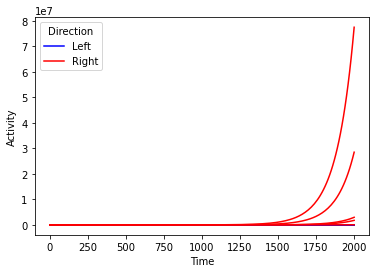

In [29]:
# hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
# hidden_states = hidden_states.detach().numpy()
directions = np.array([trial_params[i]['direction'] for i in range(trial_params.shape[0])])
colors_list = ['b', 'r']
for trial_i in range(10):
    direction = directions[trial_i]
    plt.plot(np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0]), hidden_states[trial_i, :, 0], colors_list[direction])
# plt.ylim([0,1]);
plt.legend(['Left', 'Right'], title='Direction')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.xlabel("Time")
plt.ylabel("Activity")
# plt.ylim([0,1])
plt.savefig(training_kwargs['figures_path'] + '\\hidden_activity_10.pdf')

In [30]:
coherence_list = np.linspace(.0, 0.5, 101)

with open("C:\\Users\\abel_\\Documents\\Rotations\\CIT\\experiments\\data_cohs_0_0.5.pickle", 'rb') as handle:
    data_set = pickle.load(handle)
x, y, output_mask, trial_params = data_set
inputs = torch.tensor(x, dtype=torch.float)
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)

In [31]:
#initialize hidden states
hidden = torch.zeros(rnn_model.n_layers, inputs.shape[0], rnn_model.hidden_dim) #random?
hidden_states, hidden_last = rnn_model.rnn(inputs, hidden)
hidden_states = hidden_states.detach().numpy()
flat_hidden_states = hidden_states.reshape((-1, hidden_states.shape[-1]))

yhat, _ = rnn_model(inputs)
yhat = yhat.detach().numpy()
hidden_states.shape

(10000, 200, 1)

In [32]:
directions = np.array([trial_params[i]['direction'] for i in range(trial_params.shape[0])])
coherences = np.array([trial_params[i]['coherence'] for i in range(trial_params.shape[0])])

np.where(directions==0)[0]

array([   2,    6,    7, ..., 9997, 9998, 9999], dtype=int64)

Coh:  0.135 Dir:  1


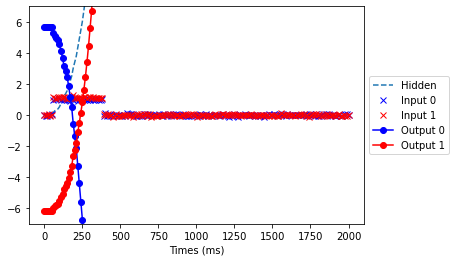

In [33]:
trial_i = 8
print("Coh: ", trial_params[trial_i]['coherence'], "Dir: ", trial_params[trial_i]['direction']) 
times = np.linspace(0, training_kwargs['T'], hidden_states[trial_i, :, 0].shape[0])
if training_kwargs['N_rec']==1:
    plt.plot(times, hidden_states[trial_i, :, 0], '--', label='Hidden')
else:
    plt.plot(times, hidden_states[trial_i, :, 0], '--', label='Hidden 0')
    plt.plot(times, hidden_states[trial_i, :, 1], '--', label='Hidden 1')
plt.plot(times, x[trial_i,:,0], 'xb', label='Input 0')
plt.plot(times, x[trial_i,:,1], 'xr', label='Input 1')

plt.plot(times, yhat[trial_i,:,0], '-ob', label='Output 0')
plt.plot(times, yhat[trial_i,:,1], '-or', label='Output 1')

# plt.plot(times, y[trial_i,:,0], 'ob')
# plt.plot(times, y[trial_i,:,1], 'or')
plt.xlabel("Times (ms)")
plt.ylim([-7,7])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)); # Put a legend to the right of the current axis
plt.savefig(training_kwargs['figures_path'] + '\\hiddenact_example_coh%s_dir%s.pdf'%(trial_params[trial_i]['coherence'], trial_params[trial_i]['direction']))

In [126]:
coherence_array = np.array([[trial_params[i]['coherence']]*200 for i in range(len(trial_params))])
flat_coherence_array = coherence_array.reshape(-1)

cmap = cm = plt.get_cmap('viridis') 
cNorm  = colors.Normalize(vmin=np.min(flat_coherence_array), vmax=np.max(flat_coherence_array))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
flat_coherence_array.shape

(2000000,)

In [35]:
x_min = np.min(flat_hidden_states[:,0])
x_max = np.max(flat_hidden_states[:,0])